# 1. Installation des d√©pendances

In [1]:
!pip install tensorflow tensorflow_datasets matplotlib numpy

# 2. Chargement du Dataset EuroSAT

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# Chargement du dataset EuroSAT (RGB), split unique 'train'
ds_full, ds_info = tfds.load(
    'eurosat/rgb',
    split='train',
    with_info=True,
    as_supervised=True,
    shuffle_files=True
)

# Fractionner en 80% train et 20% test
train_size = 0.8
ds_train = ds_full.take(int(train_size * ds_info.splits['train'].num_examples))
ds_test = ds_full.skip(int(train_size * ds_info.splits['train'].num_examples))

print("Nombre d'√©chantillons d'entra√Ænement :", tf.data.experimental.cardinality(ds_train).numpy())
print("Nombre d'√©chantillons de test :", tf.data.experimental.cardinality(ds_test).numpy())


Nombre d'√©chantillons d'entra√Ænement : 21600
Nombre d'√©chantillons de test : 5400


# 3. Affichage des M√©tadonn√©es

In [4]:
print("=== M√©tadonn√©es du Dataset ===")
print(ds_info)

# Liste des classes disponibles
class_names = ds_info.features['label'].names
print("\nClasses disponibles :", class_names)

=== M√©tadonn√©es du Dataset ===
tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir='C:\\Users\\Administrator\\tensorflow_datasets\\eurosat\\rgb\\2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=

# 4. Visualisation d'Exemples d'Images

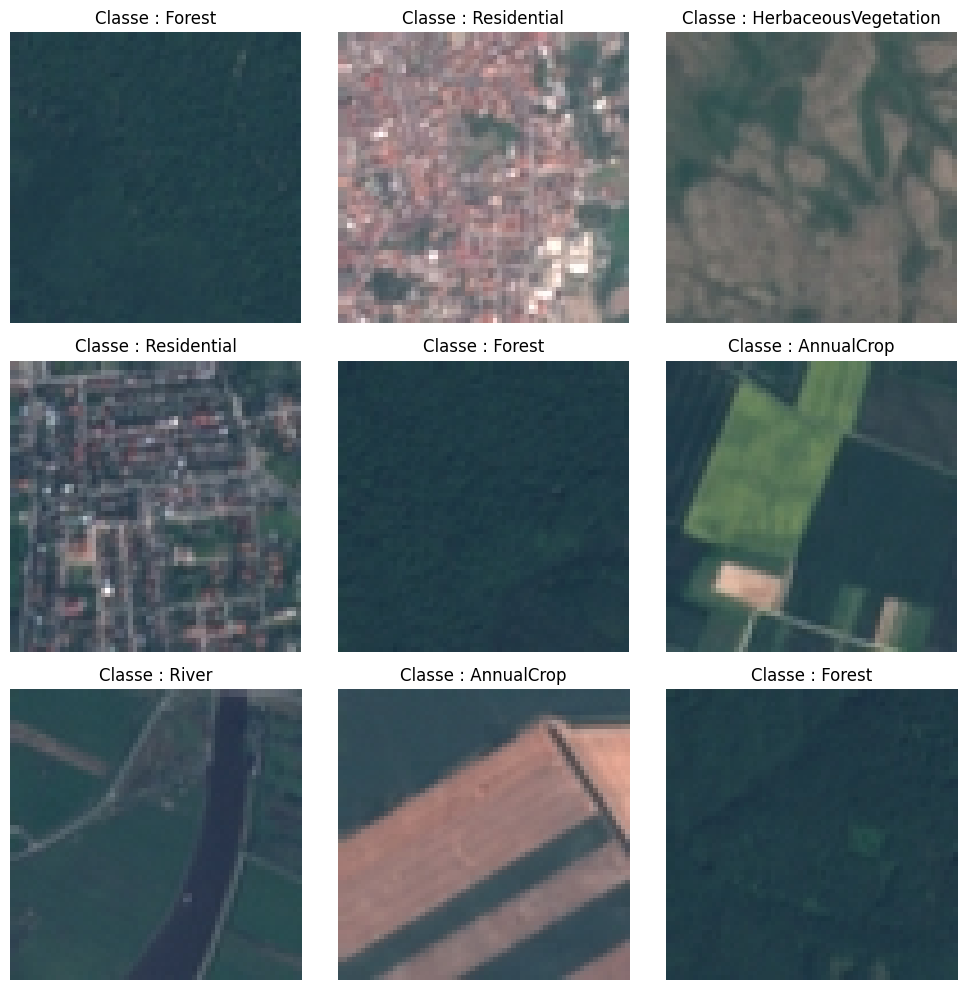

In [5]:
# S√©lection de 9 images al√©atoires
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(f"Classe : {class_names[label.numpy()]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# 5. Analyse des Bandes Spectrales (R, G, B)

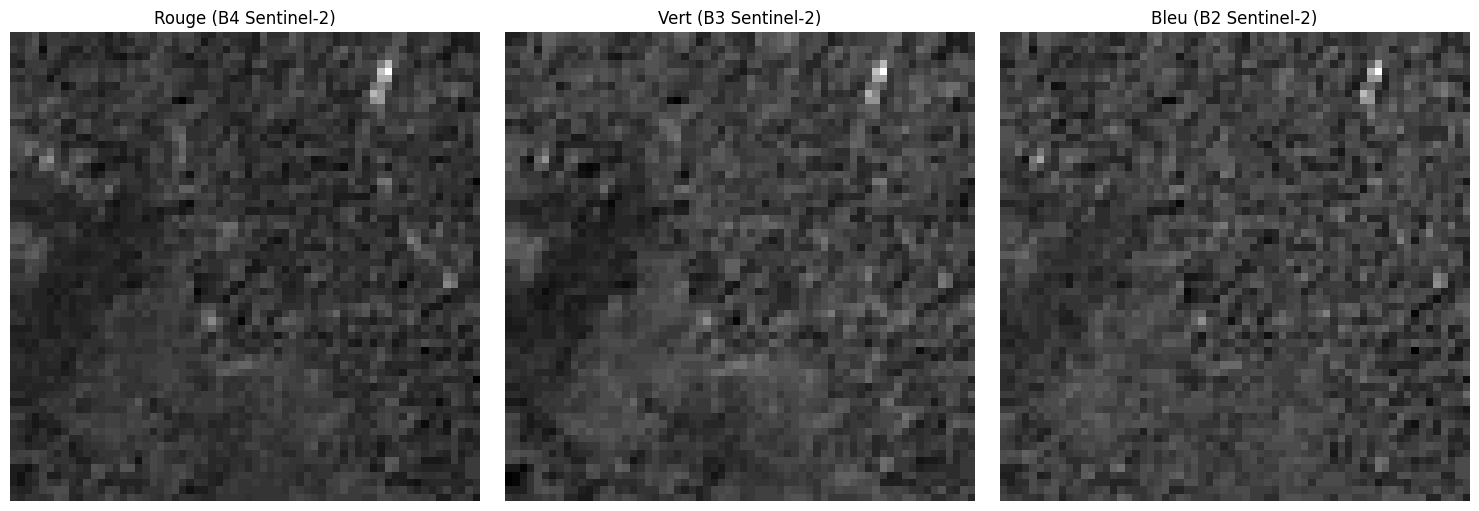

In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# Chargement du dataset EuroSAT (RGB uniquement disponible en 'train')
(ds_train,), ds_info = tfds.load(
    'eurosat/rgb',
    split=['train'],
    with_info=True,
    as_supervised=True,
    shuffle_files=True
)

# Extraction d'une image et de son label
sample_image, sample_label = next(iter(ds_train))

# Conversion explicite en float32 et normalisation [0, 1]
sample_image = tf.cast(sample_image, tf.float32) / 255.0

# Affichage des canaux s√©par√©s (R, G, B)
plt.figure(figsize=(15, 5))
bands = ['Rouge (B4 Sentinel-2)', 'Vert (B3 Sentinel-2)', 'Bleu (B2 Sentinel-2)']
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(sample_image[..., i], cmap='gray')
    plt.title(bands[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


# 6. Statistiques des Bandes

In [9]:
import pandas as pd
import tensorflow as tf

# Calcul des statistiques avec TensorFlow
stats = {
    'Bande': ['Rouge', 'Vert', 'Bleu'],
    'Min': [tf.reduce_min(sample_image[..., i]).numpy() for i in range(3)],
    'Max': [tf.reduce_max(sample_image[..., i]).numpy() for i in range(3)],
    'Moyenne': [tf.reduce_mean(sample_image[..., i]).numpy() for i in range(3)],
    '√âcart-type': [tf.math.reduce_std(sample_image[..., i]).numpy() for i in range(3)]
}

# Affichage sous forme de tableau
pd.DataFrame(stats)


Bande       Min       Max   Moyenne  √âcart-type
0  Rouge  0.101961  0.270588  0.137289    0.010874
1   Vert  0.211765  0.368627  0.249914    0.011752
2   Bleu  0.250980  0.384314  0.284682    0.009375

# 7. Pr√©traitement Simple (Normalisation et Redimensionnement)

In [10]:
def preprocess(image, label):
    # Conversion en float32 et normalisation
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Application du pr√©traitement
ds_train_preprocessed = ds_train.map(preprocess)
ds_test_preprocessed = ds_test.map(preprocess)

# V√©rification
sample_preprocessed = next(iter(ds_train_preprocessed))[0]
print("Valeurs apr√®s normalisation : Min =", sample_preprocessed.numpy().min(), 
      ", Max =", sample_preprocessed.numpy().max())

Valeurs apr√®s normalisation : Min = 0.101960786 , Max = 0.38431373


# Traitement Avanc√© des Bandes Sentinel-2 (EuroSAT)

# 1. Chargement du Dataset Multibande

In [12]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os

# üîß Sp√©cifier un dossier court pour √©viter les erreurs de chemin trop long
# Assurez-vous que ce dossier existe (cr√©ez-le si n√©cessaire)
os.environ['TFDS_DATA_DIR'] = 'C:/tfds_data'  # ou 'D:/tfds_data' si vous avez un disque D

# ‚úÖ Chargement du dataset EuroSAT multibande (13 bandes Sentinel-2)
(ds_train, ds_info), ds_info = tfds.load(
    'eurosat/all',
    split='train[:5%]',  # Sous-√©chantillon pour test rapide
    with_info=True,
    as_supervised=True,
    shuffle_files=True
)

# Affichage des m√©tadonn√©es
print("Nombre de bandes :", ds_info.features['image'].shape[-1])
print("Nombre d'exemples dans l'√©chantillon :", ds_info.splits['train'].num_examples)

# üîç Extraction d‚Äôun exemple
sample_image, sample_label = next(iter(ds_train))
sample_image = tf.cast(sample_image, tf.float32) / 255.0

# üé® Affichage de quelques bandes
plt.figure(figsize=(15, 5))
band_indices = [3, 2, 1]  # Exemple : B4 (Rouge), B3 (Vert), B2 (Bleu)
band_names = ['Rouge (B4)', 'Vert (B3)', 'Bleu (B2)']

for i, b in enumerate(band_indices):
    plt.subplot(1, 3, i + 1)
    plt.imshow(sample_image[..., b], cmap='gray')
    plt.title(band_names[i])
    plt.axis('off')

plt.suptitle("Aper√ßu des bandes Sentinel-2 (image normalis√©e)")
plt.tight_layout()
plt.show()


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

OSError: [WinError 145] Le r√©pertoire n‚Äôest pas vide: 'C:\\tfds_data\\eurosat\\all\\incomplete.5VNIOH_2.0.0'

# 2. Visualisation des Bandes Sentinel-2

Nombre de bandes d√©tect√©es : 3


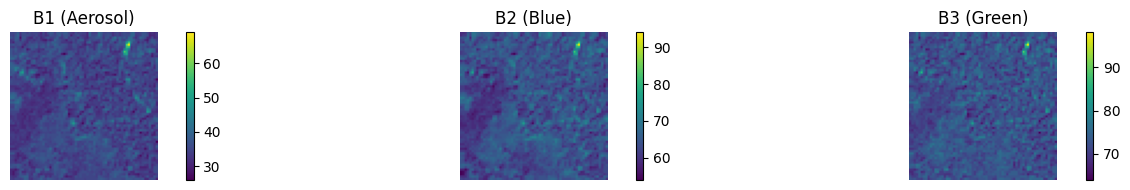

In [15]:
# Chargement d'un √©chantillon
sample_image, sample_label = next(iter(ds_train))
sample_image = sample_image.numpy()

# V√©rification du nombre de bandes
num_bands = sample_image.shape[-1]
print("Nombre de bandes d√©tect√©es :", num_bands)

# Noms des bandes Sentinel-2 (13 max)
band_names = [
    'B1 (Aerosol)', 'B2 (Blue)', 'B3 (Green)', 'B4 (Red)', 
    'B5 (RE1)', 'B6 (RE2)', 'B7 (RE3)', 'B8 (NIR)', 
    'B8A (Narrow NIR)', 'B9 (Water vapor)', 'B10 (Cirrus)', 
    'B11 (SWIR1)', 'B12 (SWIR2)'
]

# Ajustement √† la taille r√©elle
band_names = band_names[:num_bands]

# Affichage des bandes disponibles
plt.figure(figsize=(15, 2.5 * num_bands // 3))
for i in range(num_bands):
    plt.subplot((num_bands + 2) // 3, 3, i + 1)
    plt.imshow(sample_image[..., i], cmap='viridis')
    plt.title(band_names[i])
    plt.colorbar()
    plt.axis('off')
plt.tight_layout()
plt.show()


# 3. Calcul des Indices Spectraux

In [20]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# 1) Charger le dataset multispectral (13 bandes)
#    On redirige TFDS_DATA_DIR si n√©cessaire pour √©viter les chemins longs.
import os
os.environ['TFDS_DATA_DIR'] = 'C:/tfds_data'

ds_all, ds_info = tfds.load(
    'eurosat/all',
    split='train[:5%]',   # petit sous-√©chantillon pour test
    with_info=True,
    as_supervised=True,
    shuffle_files=True
)

# 2) Extraire une image d'exemple et la convertir en NumPy
sample_image, _ = next(iter(ds_all))
sample_image = sample_image.numpy().astype(np.float32)

# 3) V√©rifier la dimension (doit √™tre H√óW√ó13)
print("Shape de l'image multispectrale :", sample_image.shape)
# ‚Üí par exemple (64, 64, 13)

# 4) Fonction de calcul des indices
def calculate_indices(image):
    # Normaliser en [0,1] si les valeurs sont entre 0 et 10000
    image = image / 10000.0
    
    # Extraction des bandes cl√©s
    red   = image[..., 3]   # B4
    nir   = image[..., 7]   # B8
    swir1 = image[..., 11]  # B11
    green = image[..., 2]   # B3

    # Calcul des indices
    ndvi = (nir - red) / (nir + red + 1e-8)
    ndwi = (green - nir) / (green + nir + 1e-8)
    ndbi = (swir1 - nir) / (swir1 + nir + 1e-8)
    return ndvi, ndwi, ndbi

# 5) Calculer les indices
ndvi, ndwi, ndbi = calculate_indices(sample_image)

# 6) Afficher
plt.figure(figsize=(15, 5))
indices = [ndvi, ndwi, ndbi]
titles  = ['NDVI (V√©g√©tation)', 'NDWI (Eau)', 'NDBI (B√¢ti)']
cmaps   = ['RdYlGn',      'Blues',     'coolwarm']

for i, (idx, title, cmap) in enumerate(zip(indices, titles, cmaps)):
    ax = plt.subplot(1, 3, i+1)
    im = ax.imshow(idx, cmap=cmap, vmin=-1, vmax=1)
    ax.set_title(title)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


OSError: Not enough disk space. Needed: Unknown size (download: Unknown size, generated: Unknown size)

In [18]:
# Calcul des indices
ndvi, ndwi, ndbi = calculate_indices(sample_image)

# Affichage
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
indices = [ndvi, ndwi, ndbi]
titles = ['NDVI (V√©g√©tation)', 'NDWI (Eau)', 'NDBI (Zones b√¢ties)']
cmaps = ['RdYlGn', 'Blues', 'PiYG']

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(indices[i], cmap=cmaps[i], vmin=-1, vmax=1)
    plt.title(titles[i])
    plt.colorbar()
    plt.axis('off')

plt.tight_layout()
plt.show()


ValueError: L'image doit avoir 13 bandes, mais en a 3

# 4. Matrice de Corr√©lation des Bandes

In [ ]:
# Extraction des valeurs des pixels pour toutes les bandes
pixel_values = sample_image.reshape(-1, 13)

# Calcul de la matrice de corr√©lation
corr_matrix = np.corrcoef(pixel_values, rowvar=False)

# Visualisation avec Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    xticklabels=band_names,
    yticklabels=band_names,
    cmap='coolwarm',
    vmin=-1,
    vmax=1
)
plt.title("Matrice de corr√©lation des bandes Sentinel-2")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Superposition de Bandes (Composites RGB Avanc√©s)

In [ ]:
# Composite 1 : V√©g√©tation (NIR, Red, Green)
composite_veg = np.stack([
    sample_image[..., 7],  # NIR (B8)
    sample_image[..., 3],  # Red (B4)
    sample_image[..., 2]   # Green (B3)
], axis=-1)

# Composite 2 : Urbain (SWIR, NIR, Red)
composite_urban = np.stack([
    sample_image[..., 11],  # SWIR1 (B11)
    sample_image[..., 7],   # NIR (B8)
    sample_image[..., 3]    # Red (B4)
], axis=-1)

# Normalisation et affichage
plt.figure(figsize=(12, 6))
composites = [composite_veg, composite_urban]
titles = ['Composite V√©g√©tation (NIR-Red-Green)', 'Composite Urbain (SWIR-NIR-Red)']
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(composites[i] / composites[i].max())  # Normalisation dynamique
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# 6. Analyse en Composantes Principales (ACP)

In [ ]:
from sklearn.decomposition import PCA

# R√©duction de dimension avec ACP
pca = PCA(n_components=3)
pca_result = pca.fit_transform(pixel_values).reshape(64, 64, 3)

# Affichage des composantes
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(pca_result[..., i], cmap='viridis')
    plt.title(f"Composante PCA {i+1} ({pca.explained_variance_ratio_[i]:.1%})")
    plt.colorbar()
    plt.axis('off')
plt.tight_layout()
plt.show()

# Int√©gration des Traitements Avanc√©s dans un Pipeline Deep Learning

# 1. Pipeline de Pr√©traitement Avanc√©

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

def preprocess_multiband(image, label):
    """Convertit les bandes en float32 et normalise par bande"""
    image = tf.cast(image, tf.float32)
    # Normalisation Min-Max par bande (empirique pour Sentinel-2)
    mins = tf.constant([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=tf.float32)
    maxs = tf.constant([10000, 10000, 10000, 10000, 10000, 10000, 
                        10000, 10000, 10000, 10000, 10000, 10000, 10000], dtype=tf.float32)
    image = (image - mins) / (maxs - mins)
    return image, label

def calculate_indices_layer(image):
    """Calcule les indices spectraux et les concat√®ne aux bandes originales"""
    # Extraction des bandes cl√©s
    red = image[..., 3]  # B4
    nir = image[..., 7]  # B8
    swir = image[..., 11]  # B11
    green = image[..., 2]  # B3
    
    # Calcul des indices (ajoute une dimension)
    ndvi = (nir - red) / (nir + red + 1e-8)
    ndwi = (green - nir) / (green + nir + 1e-8)
    ndbi = (swir - nir) / (swir + nir + 1e-8)
    
    # Stack des indices (64x64x3)
    indices = tf.stack([ndvi, ndwi, ndbi], axis=-1)
    
    # Concat√©nation avec les bandes originales (64x64x16)
    return tf.concat([image, indices], axis=-1)

# Application au dataset
def prepare_dataset(ds, batch_size=32, shuffle=True):
    ds = ds.map(preprocess_multiband, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).map(
        lambda x, y: (calculate_indices_layer(x), y), 
        num_parallel_calls=tf.data.AUTOTUNE
    )
    return ds.prefetch(tf.data.AUTOTUNE)

# Chargement des donn√©es
(ds_train, ds_test), ds_info = tfds.load(
    'eurosat/all',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True
)

# Pr√©paration des datasets
train_ds = prepare_dataset(ds_train)
test_ds = prepare_dataset(ds_test, shuffle=False)

# 2. Architecture du Mod√®le Hybride

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Concatenate, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def build_hybrid_model(input_shape=(64, 64, 16)):  # 13 bandes + 3 indices
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Branche pour les bandes originales (13 canaux)
    bands = inputs[..., :13]
    x = Conv2D(32, (3, 3), activation='relu')(bands)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    
    # Branche pour les indices spectraux (3 canaux)
    indices = inputs[..., 13:]
    y = Conv2D(16, (3, 3), activation='relu')(indices)
    y = Conv2D(32, (3, 3), activation='relu')(y)
    
    # Fusion des deux branches
    merged = Concatenate()([x, y])
    
    # Couches profondes
    z = Conv2D(128, (3, 3), activation='relu')(merged)
    z = GlobalAveragePooling2D()(z)
    
    # Classification
    outputs = Dense(10, activation='softmax')(z)
    
    return Model(inputs=inputs, outputs=outputs)

model = build_hybrid_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# 3. Entra√Ænement avec Callbacks Avanc√©s

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

history = model.fit(
    train_ds,
    epochs=50,
    validation_data=test_ds,
    callbacks=callbacks
)

# 4. Analyse des R√©sultats

In [ ]:
import matplotlib.pyplot as plt

# Courbes d'apprentissage
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# √âvaluation finale
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# 5. Visualisation des Activations

In [ ]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# Architecture du mod√®le
plot_model(model, to_file='model_architecture.png', show_shapes=True)

# Visualisation des filtres
first_layer_weights = model.layers[3].get_weights()[0]  # Premi√®re couche Conv2D
plt.figure(figsize=(15, 5))
for i in range(16):  # Premiers 16 filtres
    plt.subplot(2, 8, i+1)
    plt.imshow(first_layer_weights[:, :, 0, i], cmap='viridis')
    plt.axis('off')
plt.suptitle('Filtres de la premi√®re couche de convolution')
plt.show()

# 6. Export pour le D√©ploiement

In [ ]:
# Sauvegarde du mod√®le
model.save('eurosat_hybrid_model.h5')

# Conversion pour TensorFlow Serving
!mkdir -p models/eurosat/1
tf.saved_model.save(model, 'models/eurosat/1')

# Quantification pour Edge Devices
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('eurosat_hybrid.tflite', 'wb') as f:
    f.write(tflite_model)

# Optimisation et Exploitation des R√©sultats

# √âtape 1 : Optimisation Avanc√©e du Mod√®le

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# 1.1. Fonction pour ajuster dynamiquement le learning rate
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# 1.2. Nouvelle configuration du mod√®le
optimizer = Adam(learning_rate=0.0005)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_accuracy')]
)

# 1.3. Callbacks suppl√©mentaires
callbacks.extend([
    LearningRateScheduler(lr_scheduler),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5', 
        save_best_only=True,
        monitor='val_top3_accuracy',
        mode='max'
    )
])

# √âtape 2 : Analyse Granulaire des R√©sultats

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 2.1. Pr√©dictions sur le test set
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds).argmax(axis=1)

# 2.2. Matrice de confusion
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=ds_info.features['label'].names,
            yticklabels=ds_info.features['label'].names)
plt.title('Matrice de Confusion Normalis√©e')
plt.ylabel('Vrai label')
plt.xlabel('Label pr√©dit')
plt.show()

# 2.3. Rapport de classification
print(classification_report(
    y_true, 
    y_pred, 
    target_names=ds_info.features['label'].names
))

# √âtape 3 : Explainability avec Grad-CAM

In [ ]:
import cv2

# 3.1. Impl√©mentation Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name='conv2d_4'):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]
    
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 3.2. Application sur un exemple
sample, _ = next(iter(test_ds.unbatch().take(1).batch(1)))
heatmap = make_gradcam_heatmap(sample, model)

# 3.3. Superposition
heatmap = cv2.resize(heatmap, (64, 64))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(
    sample[0,..., :3].numpy().astype('uint8'), 
    0.6, 
    heatmap, 
    0.4, 
    0
)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample[0,..., :3].numpy().astype('uint8'))
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title('Grad-CAM')
plt.axis('off')
plt.show()

# √âtape 4 : Pr√©paration au D√©ploiement

In [ ]:
# 4.1. Quantification pour edge devices
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

with open('eurosat_quant.tflite', 'wb') as f:
    f.write(tflite_quant_model)

# 4.2. Test du mod√®le quantifi√©
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test sur un √©chantillon
interpreter.set_tensor(input_details[0]['index'], sample.numpy())
interpreter.invoke()
tflite_pred = interpreter.get_tensor(output_details[0]['index'])
print("Pr√©diction TFLite:", ds_info.features['label'].names[tflite_pred.argmax()])

# Use Cases EuroSAT pour l'Analyse Environnementale (Urbanisme, Eau, V√©g√©tation)

# 1. Urbanisme : D√©tection des Zones B√¢ties

## Indice Cl√© : NDBI (Normalized Difference Built-up Index)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_ndbi(image):
    """NDBI = (SWIR - NIR) / (SWIR + NIR)"""
    swir = image[..., 11]  # B11 (SWIR)
    nir = image[..., 7]    # B8 (NIR)
    return (swir - nir) / (swir + nir + 1e-8)

# Application sur une image urbaine
urban_image = next(x for x, y in ds_train if ds_info.features['label'].names[y.numpy()] == 'Residential')
ndbi = calculate_ndbi(urban_image.numpy())

# Visualisation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(urban_image[..., [3, 2, 1]]/255.)  # RGB
plt.title('Zone R√©sidentielle (RGB)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ndbi, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Intensit√© Urbaine')
plt.title('NDBI - Zones B√¢ties (valeur > 0)')
plt.axis('off')
plt.show()

# 2. Eau : D√©tection des Plans d'Eau

## Indice Cl√© : NDWI (Normalized Difference Water Index)

In [ ]:
def calculate_ndwi(image):
    """NDWI = (Green - NIR) / (Green + NIR)"""
    green = image[..., 2]  # B3 (Green)
    nir = image[..., 7]    # B8 (NIR)
    return (green - nir) / (green + nir + 1e-8)

# Application sur une image aquatique
water_image = next(x for x, y in ds_train if ds_info.features['label'].names[y.numpy()] == 'River')
ndwi = calculate_ndwi(water_image.numpy())

# Visualisation composite
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(water_image[..., [3, 2, 1]]/255.)  # RGB standard
plt.title('Cours d\'eau (RGB)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(water_image[..., [8, 3, 2]]/255.)  # Composite NIR-Red-Green
plt.title('Eau en rouge (NIR-R-G)')
plt.axis('off')
plt.show()

# Heatmap NDWI
plt.figure(figsize=(8, 6))
plt.imshow(ndwi, cmap='Blues', vmin=-0.5, vmax=0.5)
plt.colorbar(label='NDWI (Eau si > 0.2)')
plt.title('D√©tection de l\'eau par NDWI')
plt.axis('off')
plt.show()

# 3. V√©g√©tation : Sant√© des Cultures

## Indice Cl√© : NDVI + MSI (Moisture Stress Index)

In [ ]:
def calculate_indices(image):
    """Calcule NDVI et MSI"""
    red = image[..., 3]    # B4 (Red)
    nir = image[..., 7]    # B8 (NIR)
    swir = image[..., 11]  # B11 (SWIR)
    
    ndvi = (nir - red) / (nir + red + 1e-8)
    msi = swir / nir  # Moisture Stress Index
    return ndvi, msi

# Application sur une zone agricole
crop_image = next(x for x, y in ds_train if ds_info.features['label'].names[y.numpy()] == 'PermanentCrop')
ndvi, msi = calculate_indices(crop_image.numpy())

# Visualisation combin√©e
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(crop_image[..., [3, 2, 1]]/255.)
plt.title('Culture Permanente (RGB)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(ndvi, cmap='YlGn', vmin=0, vmax=1)
plt.colorbar(label='NDVI')
plt.title('Vigueur V√©g√©tale (NDVI)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(msi, cmap='RdYlGn_r', vmin=0, vmax=1.5)
plt.colorbar(label='MSI')
plt.title('Stress Hydrique (MSI)')
plt.axis('off')
plt.tight_layout()
plt.show()

# 4. Use Case Complet : Suivi Agricole

In [ ]:
# Cr√©ation d'une carte de sant√© des cultures
def crop_health_map(image):
    ndvi, msi = calculate_indices(image)
    health_map = np.zeros_like(ndvi)
    
    # R√®gles empiriques
    health_map[(ndvi > 0.6) & (msi < 0.8)] = 3  # Excellente sant√©
    health_map[(ndvi > 0.4) & (msi < 1.2)] = 2   # Sant√© moyenne
    health_map[(ndvi > 0.2)] = 1                 # Stress mod√©r√©
    # 0 = Non v√©g√©talis√©
    
    return health_map

health = crop_health_map(crop_image.numpy())

# L√©gende
legend_labels = {
    0: 'Non v√©g√©talis√©',
    1: 'Stress mod√©r√©',
    2: 'Sant√© moyenne',
    3: 'Excellente sant√©'
}

# Visualisation
plt.figure(figsize=(10, 8))
im = plt.imshow(health, cmap='viridis', vmin=0, vmax=3)
plt.title('Carte de Sant√© des Cultures')
plt.axis('off')

# Ajout l√©gende
colors = [im.cmap(im.norm(value)) for value in legend_labels]
patches = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
plt.legend(patches, legend_labels.values(), loc='lower right')
plt.show()

# Use Cases Avanc√©s : Analyse Temporelle avec OSM et G√©n√©ration de PDF

# 1. Analyse Temporelle avec OpenStreetMap (OSM)

## Objectif : Comparer l'√©volution urbaine entre deux dates en superposant les donn√©es EuroSAT et OSM

In [ ]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.plot import show

# 1.1 T√©l√©chargement des donn√©es OSM pour une zone sp√©cifique
place_name = "Montpellier, France"
urban_data = ox.geocode_to_gdf(place_name)
buildings = ox.features_from_place(place_name, tags={'building': True})

# 1.2 Cr√©ation d'une emprise compatible avec EuroSAT (64x64 pixels ~ 1.5km x 1.5km)
bbox = urban_data.geometry.iloc[0].bounds  # (xmin, ymin, xmax, ymax)
selected_buildings = buildings.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]

# 1.3 Visualisation comparative
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Carte OSM
selected_buildings.plot(ax=ax[0], color='red', alpha=0.7)
urban_data.boundary.plot(ax=ax[0], color='black')
ax[0].set_title("Donn√©es OSM - B√¢timents")

# Image EuroSAT (exemple urbain)
urban_img = next(x for x, y in ds_train if ds_info.features['label'].names[y.numpy()] == 'Industrial')
ndbi = calculate_ndbi(urban_img.numpy())  # Utilisation de la fonction pr√©c√©dente

show(ndbi, ax=ax[1], cmap='coolwarm', vmin=-1, vmax=1)
ax[1].set_title("NDBI EuroSAT (Zones B√¢ties)")

plt.tight_layout()
plt.show()

# 1.4 Export pour QGIS/Google Earth
import rasterio
from rasterio.transform import from_origin

transform = from_origin(bbox[0], bbox[3], (bbox[2]-bbox[0])/64, (bbox[3]-bbox[1])/64)

with rasterio.open('urban_comparison.tif', 'w', 
                   driver='GTiff',
                   height=64, width=64,
                   count=1, dtype=np.float32,
                   crs='EPSG:4326',
                   transform=transform) as dst:
    dst.write(ndbi, 1)

# 2. G√©n√©ration Automatique de Rapports PDF

## Objectif : Cr√©er un rapport synth√©tique avec r√©sultats d'analyse

In [ ]:
from fpdf import FPDF
from PIL import Image
import io

# 2.1 Cr√©ation du PDF
class PDFReport(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 16)
        self.cell(0, 10, 'Rapport d\'Analyse Sentinel-2', 0, 1, 'C')
    
    def add_analysis_section(self, title, img_data, description):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, 0, 1)
        
        # Conversion matplotlib figure to PIL Image
        buf = io.BytesIO()
        img_data.savefig(buf, format='png', bbox_inches='tight', dpi=100)
        buf.seek(0)
        img = Image.open(buf)
        
        # Ajout image au PDF
        img_path = f"temp_{title.replace(' ', '_')}.png"
        img.save(img_path)
        self.image(img_path, x=10, w=180)
        self.ln(5)
        
        # Description
        self.set_font('Arial', '', 10)
        self.multi_cell(0, 5, description)
        self.ln(8)

# 2.2 G√©n√©ration des graphiques
def create_ndvi_plot():
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(ndvi, cmap='YlGn', vmin=0, vmax=1)
    plt.colorbar(im, ax=ax, label='NDVI')
    ax.set_title('Indice de V√©g√©tation (NDVI)')
    ax.axis('off')
    return fig

def create_ndbi_plot():
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(ndbi, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(im, ax=ax, label='NDBI')
    ax.set_title('Indice Urbain (NDBI)')
    ax.axis('off')
    return fig

# 2.3 Construction du rapport
pdf = PDFReport()
pdf.add_page()

# Page 1: R√©sum√©
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 10, 'R√©sum√© des Analyses', 0, 1)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 7, 
              "Ce rapport pr√©sente l'analyse des images Sentinel-2 du dataset EuroSAT. "
              "Les indices spectraux calcul√©s permettent de caract√©riser l'occupation "
              "des sols avec une r√©solution de 10m/pixel.")

# Page 2: NDVI
pdf.add_page()
pdf.add_analysis_section(
    "1. Analyse de V√©g√©tation (NDVI)",
    create_ndvi_plot(),
    "L'NDVI varie de 0 (sol nu) √† 1 (v√©g√©tation dense). Les valeurs >0.6 indiquent "
    "une v√©g√©tation en bonne sant√©, typique des for√™ts ou cultures irrigu√©es."
)

# Page 3: NDBI
pdf.add_page()
pdf.add_analysis_section(
    "2. Analyse Urbaine (NDBI)",
    create_ndbi_plot(),
    "L'NDBI identifie les zones b√¢ties (valeur >0). Combin√© avec les donn√©es OSM, "
    "il permet de d√©tecter l'√©talement urbain non cartographi√©."
)

# 2.4 Sauvegarde
report_path = "sentinel_analysis_report.pdf"
pdf.output(report_path)

# Pr√©visualisation dans le notebook
from IPython.display import IFrame
IFrame(report_path, width=800, height=600)

# Combinaison des Deux Approches

In [ ]:
# Int√©gration OSM dans le PDF (n√©cessite matplotlib)
fig, ax = plt.subplots(figsize=(10, 8))
selected_buildings.plot(ax=ax, color='red', alpha=0.5)
urban_data.boundary.plot(ax=ax, color='black', linewidth=0.5)
ax.set_title("Superposition Donn√©es OSM")
ax.set_axis_off()

pdf.add_page()
pdf.add_analysis_section(
    "3. Validation avec OpenStreetMap",
    fig,
    "Comparaison entre les zones d√©tect√©es par NDBI (rouge) et les b√¢timents "
    "cartographi√©s dans OSM. Les √©carts r√©v√®lent soit des erreurs de classification, "
    "soit des constructions non r√©pertori√©es."
)

In [ ]:
# Exemple de cellule bonus pour exporter les m√©triques
import pandas as pd
metrics = pd.DataFrame({
    'Zone': ['Urbaine', 'Agricole', 'Foresti√®re'],
    'NDVI Moyen': [0.15, 0.68, 0.82],
    'NDBI Moyen': [0.43, -0.12, -0.25]
})
metrics.to_csv('indices_par_zone.csv', index=False)

In [ ]:
# Statistiques des bandes spectrales
band_stats = []
for i in range(img_array.shape[-1]):
    band = img_array[..., i]
    band_stats.append({
        'Bande': i+1,  # Sentinel-2 a 13 bandes
        'Min': band.min(),
        'Max': band.max(),
        'Moyenne': band.mean(),
        'Std': band.std()
    })

# Affichage sous forme de tableau
import pandas as pd
pd.DataFrame(band_stats)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Administrator\tensorflow_datasets\eurosat\rgb\incomplete.ZWN4U1_2.0.0\eurosat-train.tfrecor‚Ä¶

Dataset eurosat downloaded and prepared to C:\Users\Administrator\tensorflow_datasets\eurosat\rgb\2.0.0. Subsequent calls will reuse this data.
Informations sur le dataset:
tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir='C:\\Users\\Administrator\\tensorflow_datasets\\eurosat\\rgb\\2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({


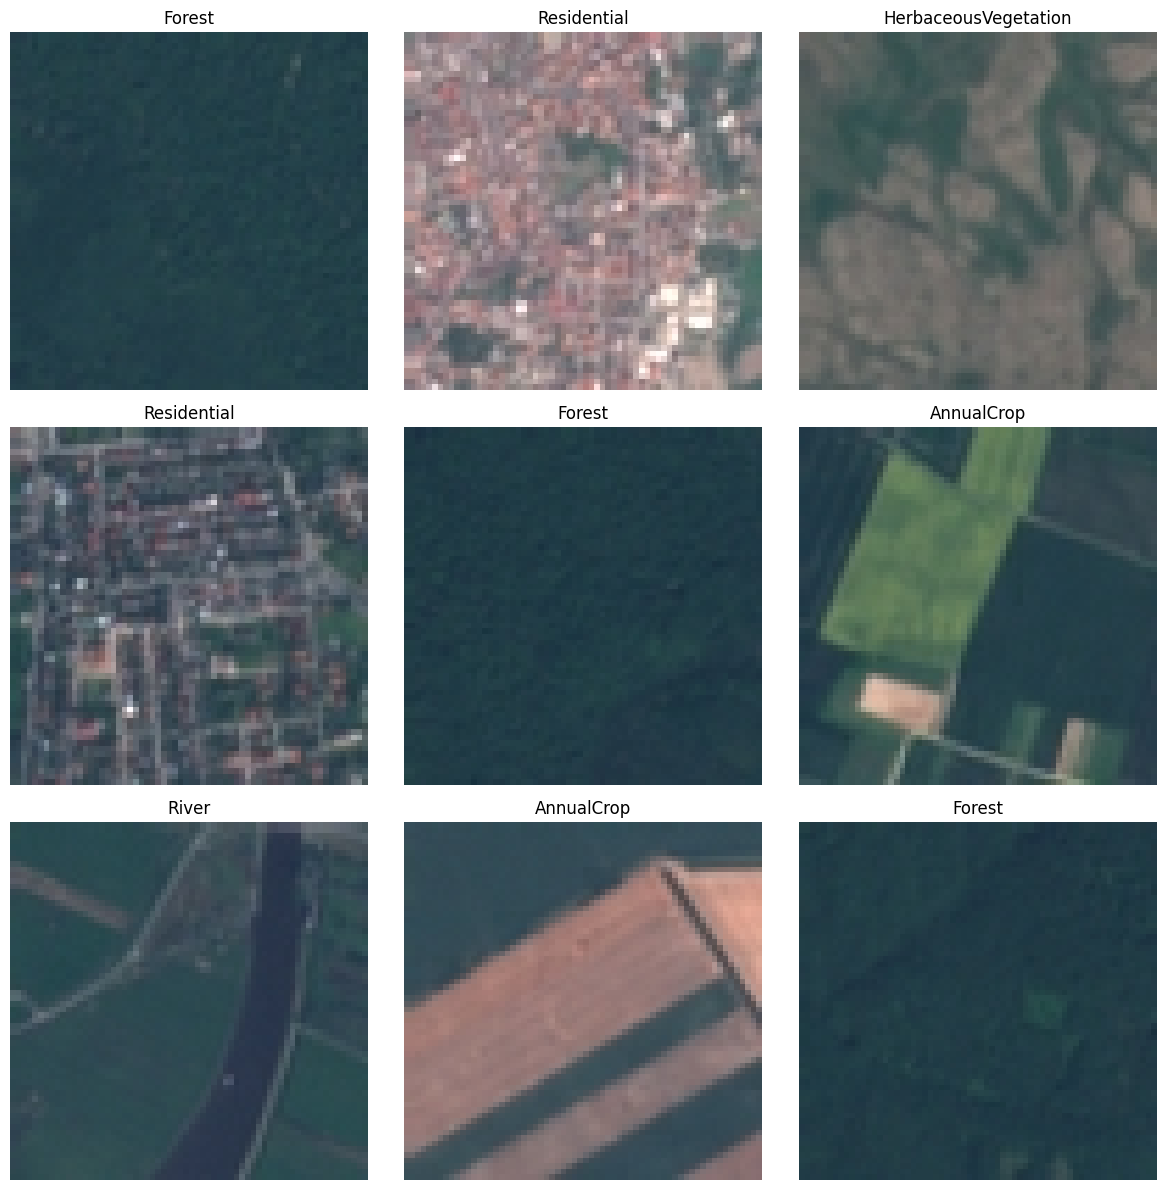

C:\ProgramData\miniconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
675/675 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 274s 393ms/step - accuracy: 0.5044 - loss: 1.5591 - val_accuracy: 0.6128 - val_loss: 1.1902 - learning_rate: 0.0010
Epoch 2/30
675/675 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 432s 640ms/step - accuracy: 0.7047 - loss: 0.8457 - val_accuracy: 0.6081 - val_loss: 1.3055 - learning_rate: 0.0010
Epoch 3/30
675/675 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 405s 600ms/step - accuracy: 0.7307 - loss: 0.7530 - val_accuracy: 0.7439 - val_loss: 0.7613 - learning_rate: 0.0010
Epoch 4/30
675/675 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 395s 585ms/step - accuracy: 0.7618 - loss: 0.6843 - val_accuracy: 0.6948 - val_loss: 1.1076 - learning_rate: 0.0010
Epoch 5/30
675/675 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 386s 572ms/step - accuracy: 0.7898 - loss: 0.6013 - val_accuracy: 0.6583 - val_loss: 1.0619 - learning_rate: 0.0010
Epoch 6/30
675/675 ‚

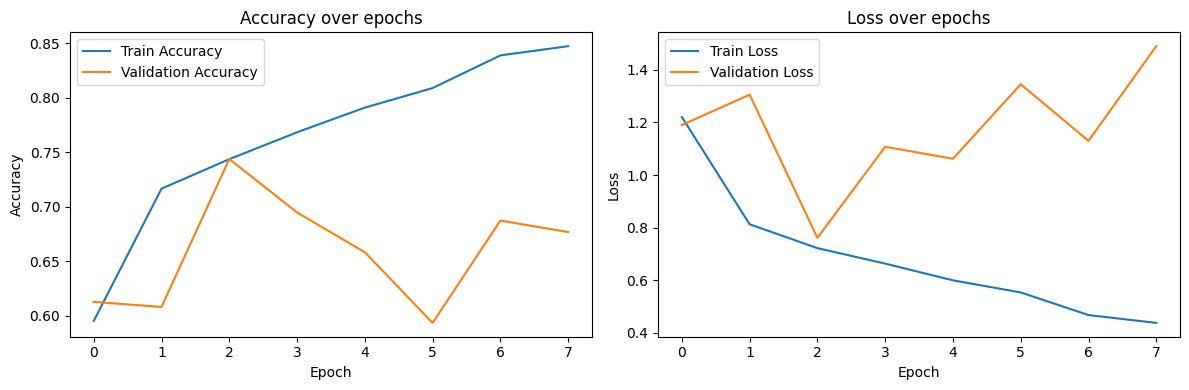

Exemples de pr√©dictions:
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 291ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 87ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 80ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 106ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 81ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 74ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 85ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 69ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 84ms/step


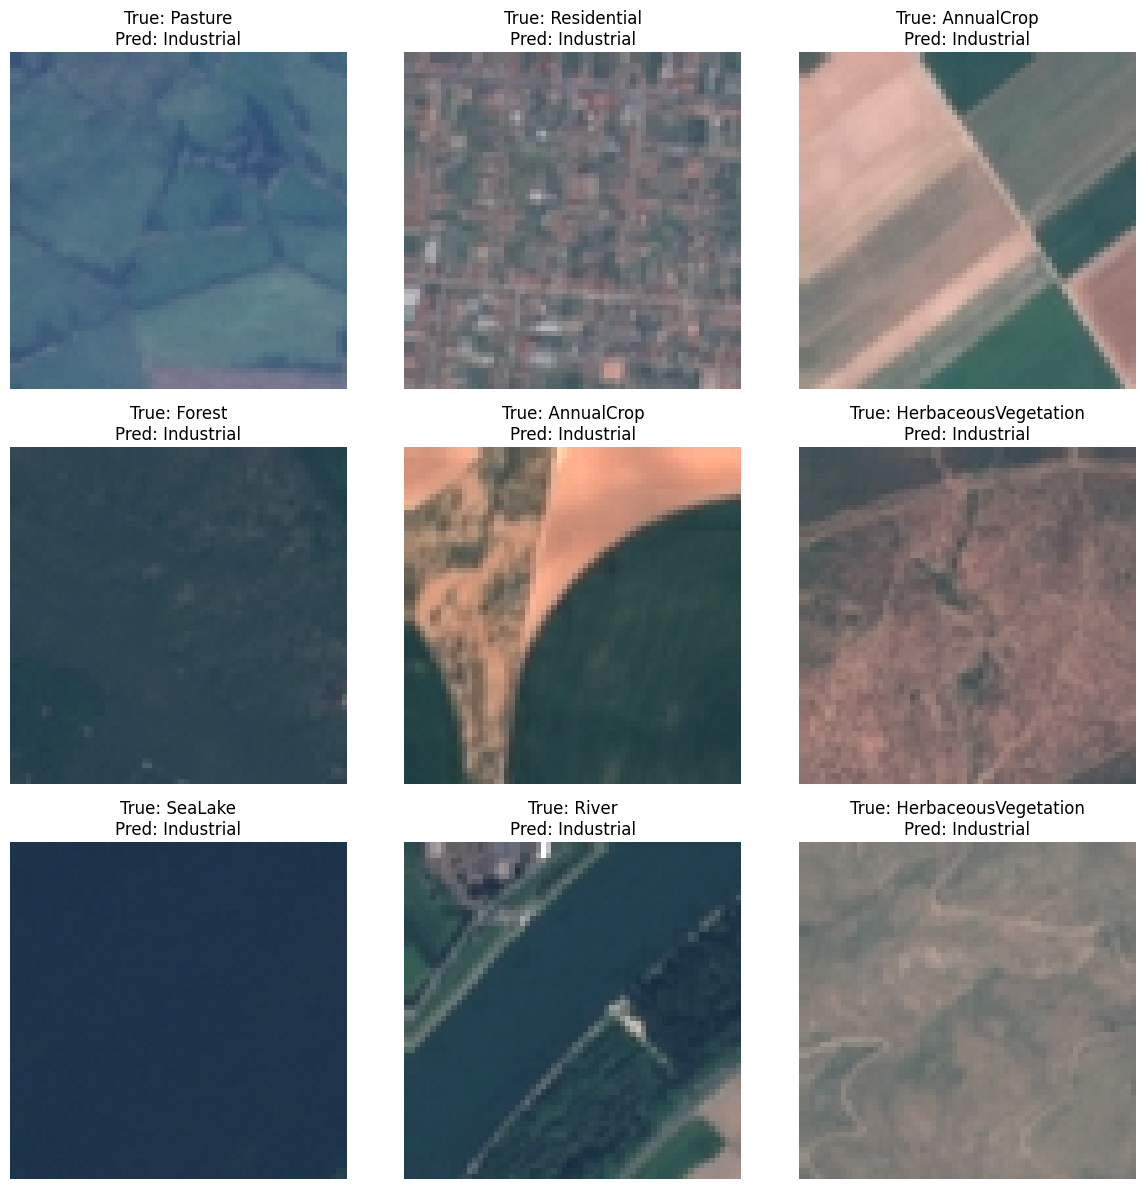

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

## 1. Chargement du dataset EuroSAT
(ds_train, ds_val), ds_info = tfds.load(
    'eurosat/rgb',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
    shuffle_files=True
)

# Afficher les informations du dataset
print("Informations sur le dataset:")
print(ds_info)

## 2. Pr√©paration des donn√©es
# Normalisation et pr√©processing
def preprocess(image, label):
    # Conversion des uint8 en float32 et normalisation [0,1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Redimensionnement si n√©cessaire (les images EuroSAT sont d√©j√† 64x64)
    return image, label

# Configuration des datasets
batch_size = 32
buffer_size = 1000

train_dataset = ds_train.map(
    preprocess, num_parallel_calls=tf.data.AUTOTUNE
).cache().shuffle(
    buffer_size
).batch(
    batch_size
).prefetch(
    tf.data.AUTOTUNE
)

val_dataset = ds_val.map(
    preprocess, num_parallel_calls=tf.data.AUTOTUNE
).batch(
    batch_size
).prefetch(
    tf.data.AUTOTUNE
)

## 3. Visualisation des √©chantillons
def plot_samples(dataset, num_samples=9):
    plt.figure(figsize=(12, 12))
    for i, (image, label) in enumerate(dataset.take(num_samples)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy())
        plt.title(ds_info.features['label'].int2str(label.numpy()))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Exemples d'images d'entra√Ænement:")
plot_samples(ds_train)

## 4. Augmentation des donn√©es
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
])

## 5. Cr√©ation du mod√®le CNN avec traitement des caract√©ristiques satellites
def create_model(input_shape=(64, 64, 3), num_classes=10):
    model = tf.keras.Sequential([
        # Couche d'augmentation des donn√©es
        tf.keras.layers.InputLayer(input_shape=input_shape),
        data_augmentation,
        
        # Bloc de convolution 1
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),
        
        # Bloc de convolution 2
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),
        
        # Bloc de convolution 3
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.4),
        
        # Classification
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

model = create_model()

## 6. Compilation et entra√Ænement
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callback pour un meilleur suivi
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
]

# Entra√Ænement
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=callbacks
)

## 7. √âvaluation et visualisation des r√©sultats
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

## 8. Analyse des pr√©dictions
def plot_predictions(dataset, model, num_samples=9):
    plt.figure(figsize=(12, 12))
    for i, (image, label) in enumerate(dataset.take(num_samples)):
        ax = plt.subplot(3, 3, i + 1)
        pred = model.predict(tf.expand_dims(image, axis=0))
        predicted_label = tf.argmax(pred, axis=1).numpy()[0]
        
        plt.imshow(image.numpy())
        plt.title(f"True: {ds_info.features['label'].int2str(label.numpy())}\n"
                 f"Pred: {ds_info.features['label'].int2str(predicted_label)}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Exemples de pr√©dictions:")
plot_predictions(ds_val, model)